In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('seaborn')

In [2]:
data_df = pd.read_csv('Data\\processed.csv')

pre-process

In [3]:
# to_normalize = data_df[data_df.columns.difference(['KWH'])]

# kwh = data_df['KWH']
# data_df.drop(columns = 'KWH', inplace=True)

# df_to_normalize = Normalizer().fit_transform(to_normalize)
# df_to_normalize = pd.DataFrame(df_to_normalize)
# df_to_normalize.columns = data_df.columns

# data_df = pd.concat([df_to_normalize, kwh],axis = 1)
# print(data_df)

In [4]:
def plotVariance(X):
  pca = PCA(n_components=20)
  pca.fit(X)
  plt.figure()
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('Number of Components')
  plt.ylabel('Variance (%)')
  plt.title('Explained Variance')
  plt.show()

In [5]:
X = data_df[data_df.columns.difference(['KWH'])]
Y = data_df['KWH']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle = True, random_state = 42)

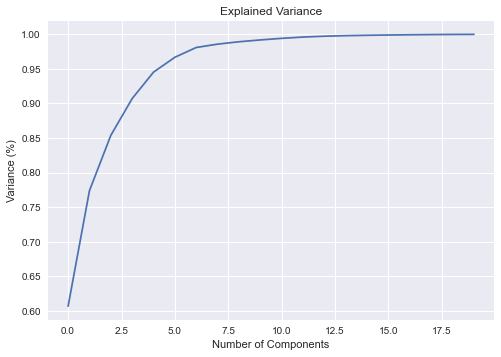

In [6]:
plotVariance(X_train)

In [7]:
PCA_train = PCA(n_components=10)
PCA_train.fit(X_train, Y_train)

dataPCA_train = PCA_train.transform(X_train)
dataPCA_test = PCA_train.transform(X_test)


models implementation

In [8]:
reg = LinearRegression().fit(dataPCA_train, Y_train)
print(reg.score(dataPCA_test, Y_test))
print(reg.score(dataPCA_train, Y_train))
print("\n\n")
lasso = Lasso(alpha=0.01)
lasso.fit(dataPCA_train, Y_train)
print(lasso.score(dataPCA_test, Y_test))
print(lasso.score(dataPCA_train, Y_train))

0.9719722092920277
0.9842402518015939



0.971972209301127
0.9842402518015939


High Correlation 

In [64]:
# isomap = Isomap(n_components=20)
# isomap = isomap.fit(X_train)

# dataISOMAP_train = isomap.transform(X_train)
# dataISOMAP_test = isomap.transform(X_test)

# reg = LinearRegression().fit(dataISOMAP_train, Y_train)
# print(reg.score(dataISOMAP_test, Y_test))

# lasso = Lasso(alpha=0.01)
# lasso.fit(dataISOMAP_train, Y_train)
# print(lasso.score(dataISOMAP_test, Y_test))

In [ ]:
print("\n\n Train summary: \n\n")
print("\n\n R2 Score: {} ".format(model.score(X_train, y_train)))
print("\n\n MSE Score: {} ".format(mean_squared_error(X_train, y_train)))
print("\n\n MAE Score: {} ".format(mean_absolute_error(X_train, y_train)))

print("\n\n Test summary: \n\n")
print("\n\n R2 Test Score: {} ".format(model.score(X_test, y_test)))
print("\n\n MSE Score: {} ".format(mean_squared_error(X_test, y_test)))
print("\n\n MAE Score: {} ".format(mean_absolute_error(X_test, y_test)))